In [0]:
import pandas as pd
from google.colab import drive 
drive.mount('/gdrive', force_remount=True)
import tensorflow.compat.v1 as tf
import numpy as np
import seaborn as sns

Mounted at /gdrive


In [0]:
df_train = pd.read_csv("/gdrive/My Drive/Kaggle/nlp-getting-started/train.csv")
df_test = pd.read_csv("/gdrive/My Drive/Kaggle/nlp-getting-started/test.csv")
df_=pd.concat([df_train, df_test], axis=0)
df_.reset_index(inplace=True)
df_.drop(['index'],axis=1, inplace=True)
split_length = df_train.shape[0]

In [0]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


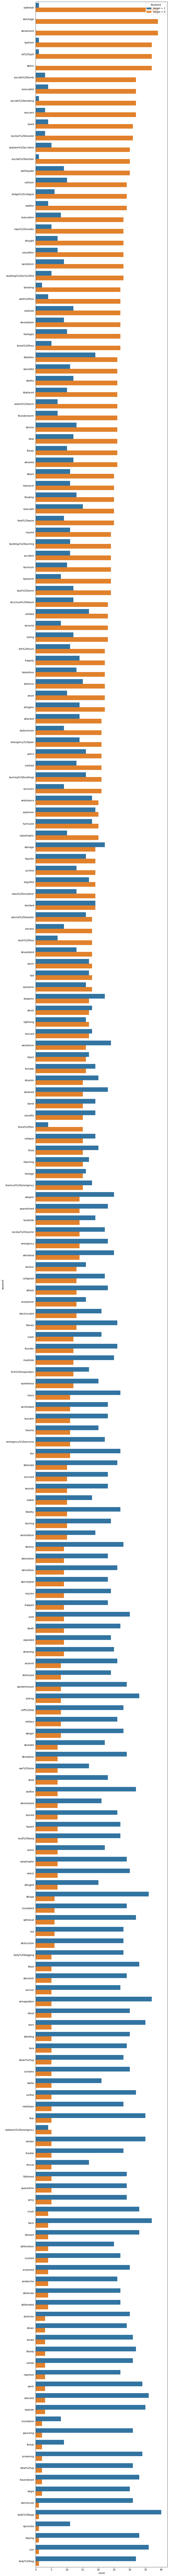

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,200))
sns.countplot(y=df_train['keyword'], hue=df_train['target'], orient='v',order = df_train.loc[(df_train.target == 1)]['keyword'].value_counts().index,)
plt.legend(title='Keyword', loc='upper right', labels=['target = 1', 'target = 0'])
plt.show()

In [0]:
print(df_train['location'].describe())
print('Nombre de Nan:', df_train['location'].isna().sum())

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object
Nombre de Nan: 2533


In [0]:
print(df_train['keyword'].describe())
print('Nombre de Nan:', df_train['keyword'].isna().sum())

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object
Nombre de Nan: 61


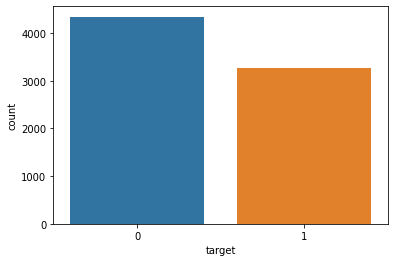

In [0]:
sns.countplot(x=df_train['target'])

In [0]:
target_ratio = sum(df_train['target'])/len(df_train['target'])
print("Fraction de target valant 1 = {:.3f}".format(target_ratio))

Fraction de target valant 1 = 0.430


In [0]:
from keras.utils import to_categorical
target=df_train.target.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

In [0]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [0]:
import re
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df_['text']=df_['text'].apply(lambda x : remove_html(x)) # Delete html expressions

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_['text']=df_['text'].apply(lambda x: remove_emoji(x)) # Delete emojis and symbols

In [0]:
!pip install pyspellchecker 

from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split()) # Attention case sensitive
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df_['text']=df_['text'].apply(lambda x:correct_spellings(x)) # Correct the misspelling

In [0]:
# Cleaning
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

stop_words = stopwords.words('english') # Words without information 
porter = PorterStemmer()
new_phrase=[]
# Text cleaning

for i in range(df_.shape[0]):
  words = df_['text'].iloc[i]
  tokens = word_tokenize(words)
  tok = [word for word in tokens if word.isalpha()]
  tok = [word.lower() for word in tok]
  tok_ = [word for word in tok if not word in stop_words]
  stemmed = [porter.stem(word) for word in tok_]
  stemmed_ = [word for word in stemmed if word != "http"] # Delete the URL
  new_phrase.append(stemmed_)
df_['NewText'] = new_phrase # liste de mots racinalisés en lower case et sans ponctuation

In [0]:
length=[]
for e in new_phrase:
  length.append(len(e))
max_length = max(length)# Nombre de mots distincts dans l'avis en contenant le plus

In [0]:
count=0
score=[]
j=0
for i in df_['NewText']:
  if len(i) == 0:
    count+=1 # Nombre de ligne ou aucun mot n'apparait (à priori la target devrait être égale à 0)
    score.append(df_['target'].iloc[j])
  j+=1

In [0]:
vocab=[]
for i in df_['NewText']:
  vocab+=i
len(vocab) # On concatene ici tous les avis nettoyés

93210

In [0]:
import collections
cnt = collections.Counter() # On crée un compteur pour compter l'apparition de chaque mot
for word in vocab:
  cnt[word] += 1

In [0]:
cnt.most_common(10)

[('like', 587),
 ('fire', 520),
 ('amp', 510),
 ('get', 452),
 ('via', 323),
 ('bomb', 321),
 ('new', 320),
 ('one', 290),
 ('news', 287),
 ('go', 284)]

In [0]:
min_occurane = 2 # On filtre les mots apparaissante moins de min_occurane fois
tokens = [k for k,c in cnt.items() if c >= min_occurane] # Liste des mots distincts conservés
n_words = len(tokens)
print(n_words)

6203


In [0]:
df_copy=df_.copy() # On crée un copie du DF original pour ne pas risquer d'écraser les data
for i in range(df_['NewText'].shape[0]):
  token_ =[w for w in df_['NewText'].iloc[i] if w in tokens]
  df_copy.at[i,'NewText'] = token_ # la colonne 'Text' est recréee et appelée 'NewText'. Elle correspond à la colonne 'Phrase' mais totalement nettoyée:
  # Plus de ponctuation, plus de uppercase, uniquement de mots racinalisés, plus de stop_words

In [0]:
lenght=[]
for i in df_['NewText']:
  length.append(len(i))
max_length = max(length) # Avis ayant le plus grands nombre de mots après nettoyage

In [0]:
from keras.preprocessing import sequence
X=[]
Y=[]
for i in range(df_.shape[0]):
  X.append(df_['NewText'].iloc[i]) # On crée un liste de liste contenant les 'NewText' sous forme de liste

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(X) #Fitter sur tokens: la liste de mots distincts ? Non car les mots distincts sont labélisés

X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen=max_length, padding='pre') # Zero padding pour normaliser la longueur de chaque avis

In [0]:
x_train = X[0:split_length,:] # On récupère le train_set preparé pour entrainer le NN
x_sub = X[split_length:,:] # On récupère le test set préparé pour ensuite faire une soumission

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_train, y_target, test_size=0.2, random_state=1) # On split les data en train set et validation set

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import models
from keras.losses import categorical_crossentropy
from keras.losses import sparse_categorical_crossentropy

early_stopping = EarlyStopping(min_delta = 0.005, mode = 'max', monitor='val_accuracy', patience = 2) # Eviter d'overfitter
callback = [early_stopping]

In [0]:
from tensorflow.keras.optimizers import Adam
model=models.Sequential()
model.add(layers.Embedding(input_dim=n_words, output_dim=100, input_length=max_length))
model.add(layers.LSTM(32, dropout=0.5,recurrent_dropout=0.5, return_sequences=False))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes,activation='sigmoid'))
opt = Adam(learning_rate=3e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.summary()

In [0]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=12, batch_size=128, verbose=1, callbacks=callback)

Epoch 1/12
48/48 [==============================] - 3s 61ms/step - loss: 0.6900 - accuracy: 0.5512 - val_loss: 0.6824 - val_accuracy: 0.5791
Epoch 2/12
48/48 [==============================] - 3s 56ms/step - loss: 0.6759 - accuracy: 0.5681 - val_loss: 0.6619 - val_accuracy: 0.5791
Epoch 3/12
48/48 [==============================] - 3s 57ms/step - loss: 0.6535 - accuracy: 0.6228 - val_loss: 0.6211 - val_accuracy: 0.6894
Epoch 4/12
48/48 [==============================] - 3s 57ms/step - loss: 0.5846 - accuracy: 0.7534 - val_loss: 0.5256 - val_accuracy: 0.7886
Epoch 5/12
48/48 [==============================] - 3s 56ms/step - loss: 0.4703 - accuracy: 0.8205 - val_loss: 0.4595 - val_accuracy: 0.7991
Epoch 6/12
48/48 [==============================] - 3s 55ms/step - loss: 0.3941 - accuracy: 0.8460 - val_loss: 0.4446 - val_accuracy: 0.8089
Epoch 7/12
48/48 [==============================] - 3s 56ms/step - loss: 0.3470 - accuracy: 0.8718 - val_loss: 0.4545 - val_accuracy: 0.8070
Epoch 8/12
48

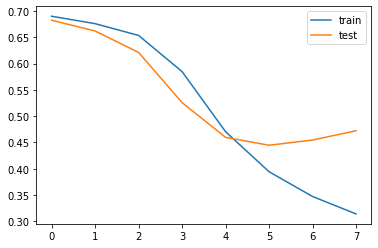

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

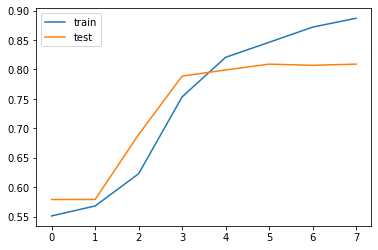

In [0]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [0]:
pred_RNN_proba = model.predict(x_sub)

In [0]:
pred_RNN=[]
for p in range(len(pred_RNN_proba)):
  pred_RNN.append(np.argmax(pred_RNN_proba[p]))

In [0]:
df_copy_train = df_train.copy().drop(['location'],axis=1).fillna(value='Nan')
df_copy_test = df_test.copy().drop(['location'],axis=1).fillna(value='Nan')
split_train_length = df_copy_train.shape[0]
df_copy_ = pd.concat([df_copy_train.drop(['target'],axis=1),df_copy_test],axis=0)

In [0]:
dummy=pd.get_dummies(df_copy_['keyword'])
list_=list(dummy)

j=0
for n in list_:
    df_copy_[n]=dummy[n]
    j+=1
    if j>=len(list_)-1:
        break
del(dummy, list_)
df_dummy = df_copy_.drop(['id', 'keyword', 'text'], axis=1)

In [0]:
from scipy.stats import pearsonr
corr=[]
for column_name in list(df_dummy.columns):
  corr.append(np.abs(pearsonr(df_dummy[column_name].iloc[0:split_train_length],df_copy_train['target'])[0]))

In [0]:
feature_name = list(df_dummy.columns)
corr, feature_name = zip(*sorted(zip(corr, feature_name)))

In [0]:
df_dummy.drop(list(feature_name[0:30]),axis=1, inplace=True) # On supprime les 121 columns les moins corrélées à la target

In [0]:
X_train = df_dummy.iloc[0:split_train_length,:]
Y_train = df_copy_train['target'].values
X_pred = df_dummy.iloc[split_train_length:,:]

In [0]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [502]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=500)
parameters = {'penalty':['l2'],
             'solver': ['lbfgs', 'liblinear'],
             'C': [0.01,0.1,1.0,10]}
grid = GridSearchCV(estimator=logit, param_grid = parameters, cv=10)
grid.fit(x_train, y_train)
print("Train_score = %3.2f" %(grid.score(x_train, y_train)))
print("Test_score = %3.2f" %(grid.score(x_val, y_val)))
print(grid.best_params_)

Train_score = 0.75
Test_score = 0.74
{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}


In [0]:
pred_logit = grid.predict_proba(X_pred)
stack_pred_proba=[]
for i in range(len(pred_logit)):
  stack_pred_proba.append(pred_logit[i][0]/2+pred_RNN_proba[i][0]/2)

In [0]:
stack_pred=[]
for i in range(len(stack_pred_proba)):
  if stack_pred_proba[i]>=0.5:
    stack_pred.append(0)
  else:
    stack_pred.append(1)

In [0]:
stack_pred

In [0]:
df_submission = pd.DataFrame()
df_submission['id'] = df_test['id']
df_submission['target'] = stack_pred

In [0]:
df_submission.to_csv(r'/gdrive/My Drive/Kaggle/nlp-getting-started/Submission/submission_6-NLP_on_text-html_and_emojis_deleted-simple_layer - stack prediction raw with logit on keyword.csv', index = False)